<a href="https://colab.research.google.com/github/Minhal-Zubair/fogforecaster/blob/main/Copy_of_updated_smog_fog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
!pip install opendatasets
import opendatasets as od
import pickle
import os
import xgboost as xgb
import lightgbm as lgb
!pip install catboost
from catboost import CatBoostClassifier



/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.6 MB/s eta 0:00:00


In [ ]:
!pip install opendatasets
od.download("https://www.kaggle.com/datasets/ahmedislam0/fog-or-smog-detection-dataset")


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: minhalzubair
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/ahmedislam0/fog-or-smog-detection-dataset


100%|██████████| 528M/528M [00:07<00:00, 73.9MB/s]


In [ ]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 20


In [ ]:
# Prepare the dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "fog-or-smog-detection-dataset",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)



Found 2335 files belonging to 2 classes.


In [ ]:
# Partition dataset into training, validation, and test sets
def get_dataset_partition_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partition_tf(dataset)


In [ ]:
# Data preprocessing: Resize and rescale
def preprocess_image(image, label):
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    image = tf.cast(image, tf.float32) / 255.0
    return image, label
train_ds = train_ds.map(preprocess_image).cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess_image).cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.map(preprocess_image).cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [ ]:
# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])


In [ ]:
# Build the model
model = models.Sequential([
    layers.InputLayer(input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),  # Dropout for regularization
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dense(3, activation='softmax')  # Adjust output layer for 3 classes
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [ ]:
# Compile the model with a tunable learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Learning rate can be tuned
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [ ]:
# Train the model
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    verbose=1
)


Epoch 1/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 446s 7s/step - accuracy: 0.5555 - loss: 0.8368 - val_accuracy: 0.9598 - val_loss: 0.1838
Epoch 2/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 347s 6s/step - accuracy: 0.9385 - loss: 0.1955 - val_accuracy: 0.9330 - val_loss: 0.1688
Epoch 3/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 384s 6s/step - accuracy: 0.9354 - loss: 0.1950 - val_accuracy: 0.9509 - val_loss: 0.1571
Epoch 4/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 349s 6s/step - accuracy: 0.9309 - loss: 0.1993 - val_accuracy: 0.9643 - val_loss: 0.1067
Epoch 5/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 348s 6s/step - accuracy: 0.9505 - loss: 0.1468 - val_accuracy: 0.9286 - val_loss: 0.1709
Epoch 6/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 376s 6s/step - accuracy: 0.9521 - loss: 0.1464 - val_accuracy: 0.9598 - val_loss: 0.1048
Epoch 7/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 345s 6s/step - accuracy: 0.9588 - loss: 0.1235 - val_accuracy: 0.9598 - val_loss: 0.1208
Epoch 8/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 382s 6s/step - accuracy: 0.9624 - loss: 0.1199 - val_accuracy: 0.9464 - v

8/8 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.9742 - loss: 0.0899
Test Accuracy: 96.88%


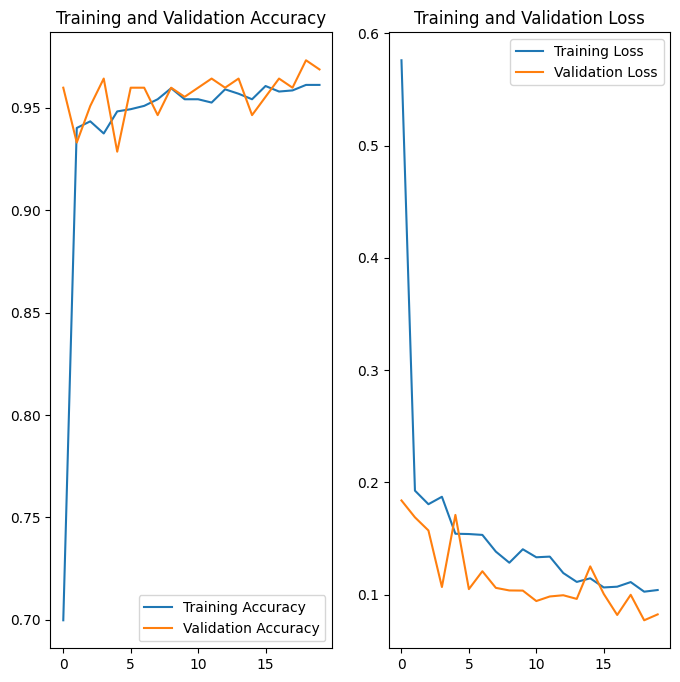

In [ ]:
# Evaluate the model
scores = model.evaluate(test_ds, verbose=1)
print(f"Test Accuracy: {scores[1] * 100:.2f}%")

# Plot training and validation metrics
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


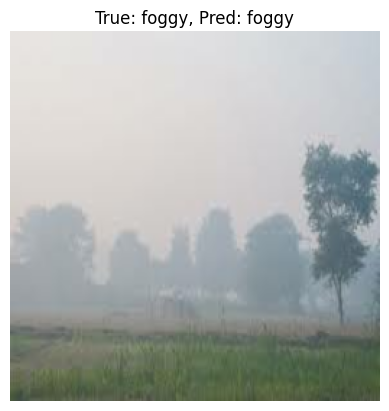

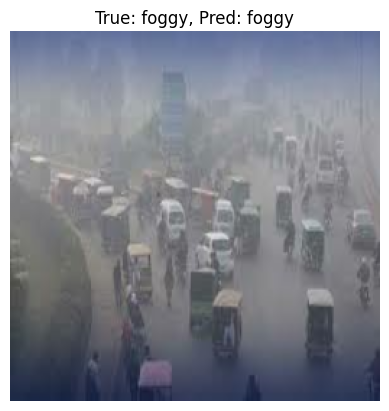

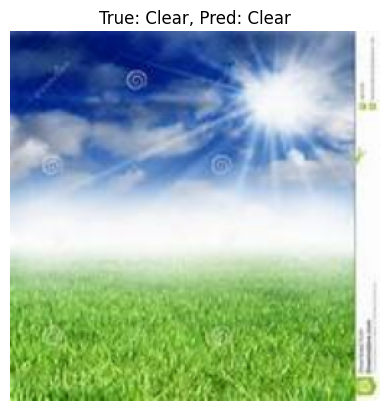

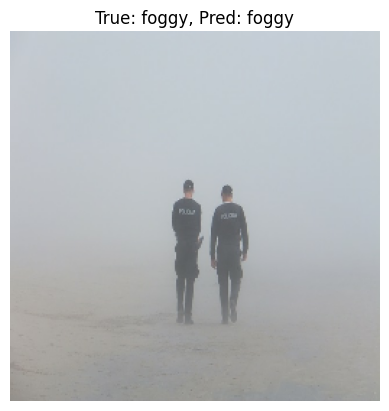

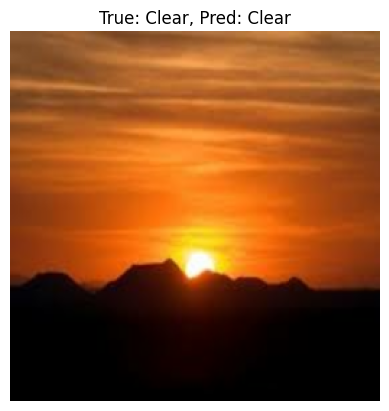

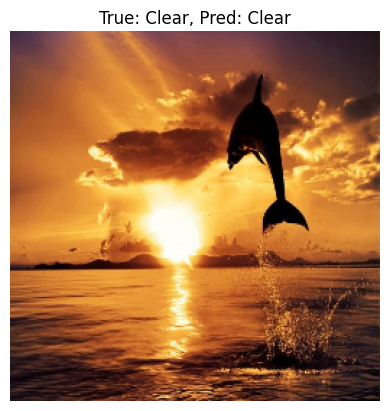

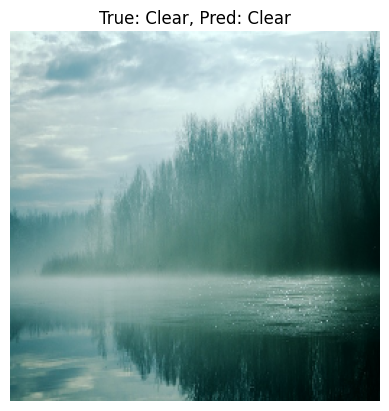

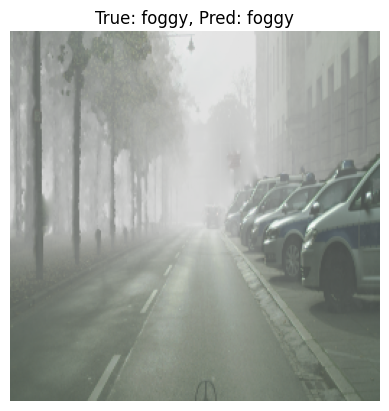

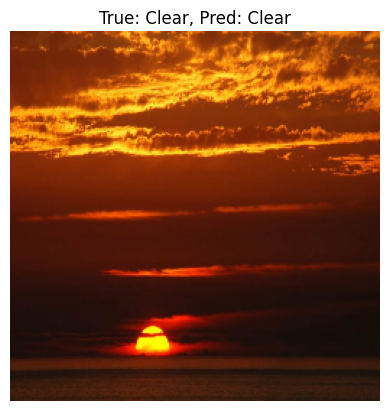

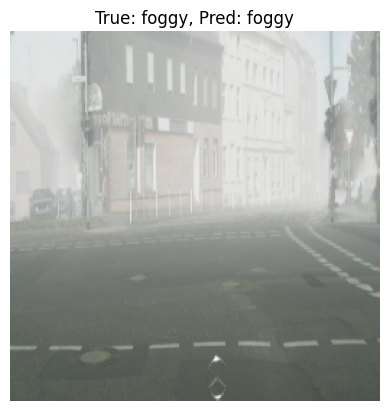

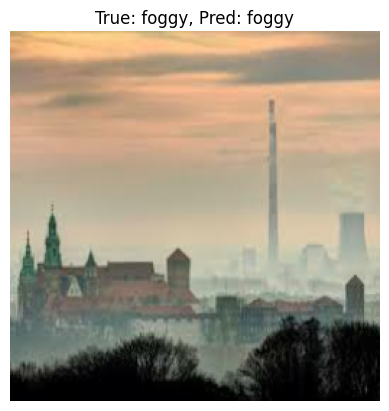

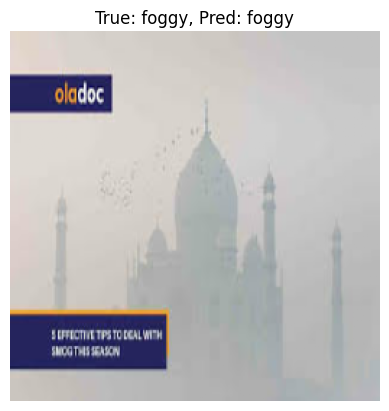

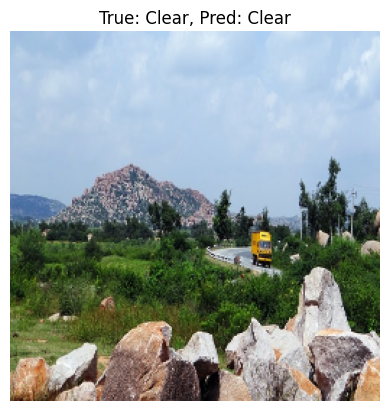

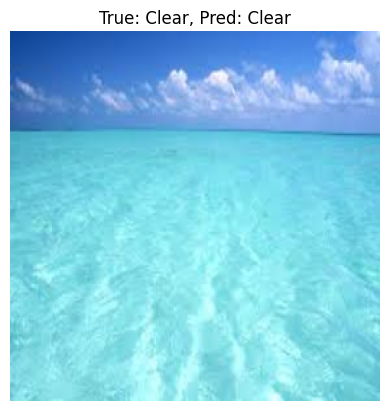

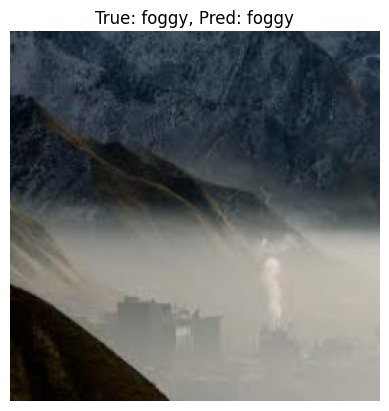

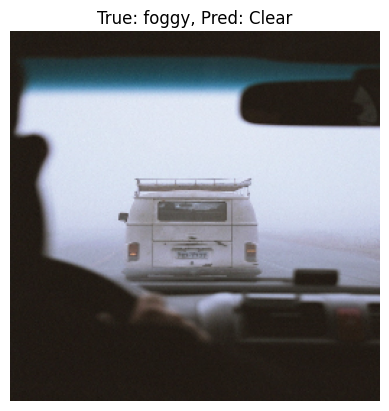

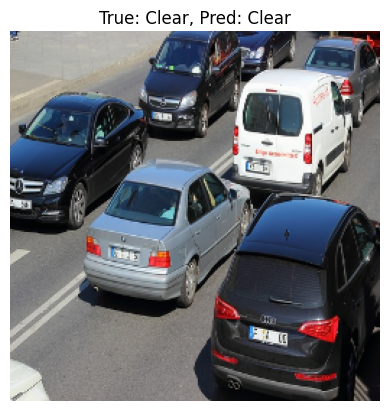

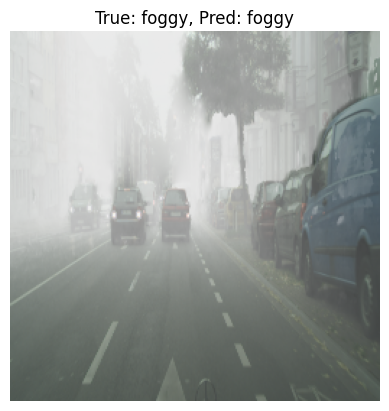

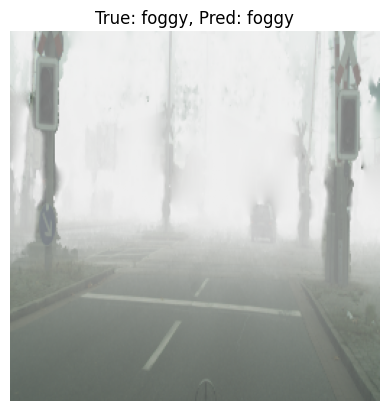

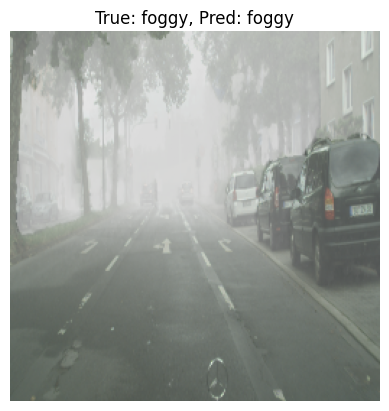

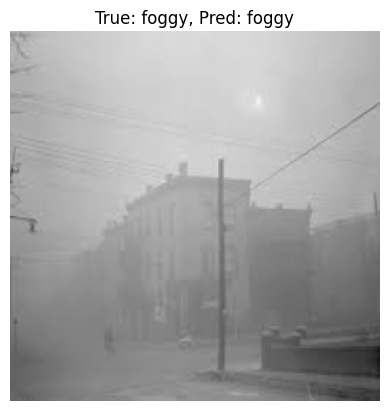

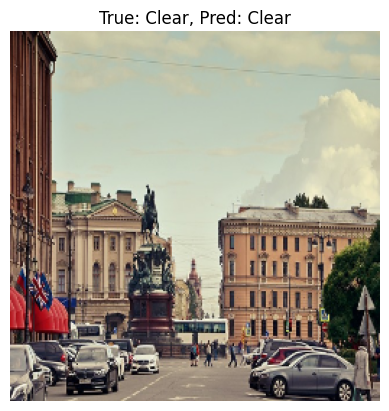

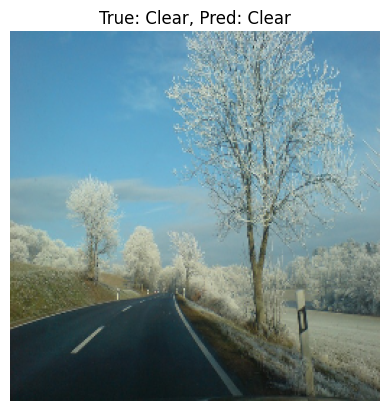

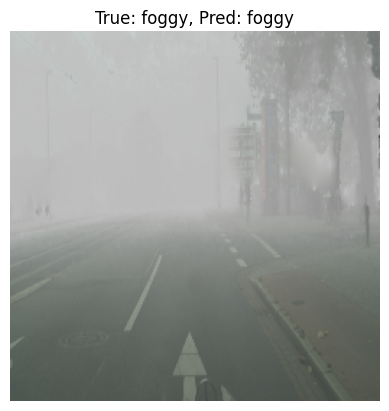

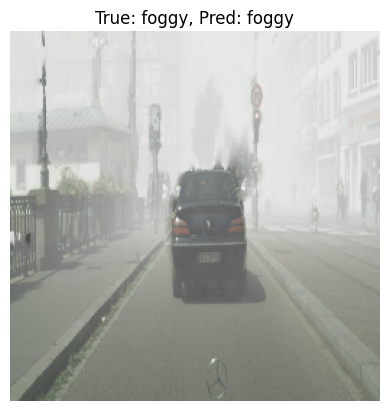

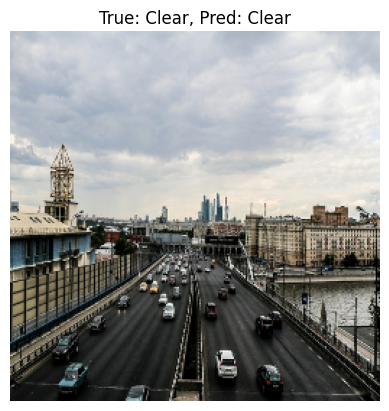

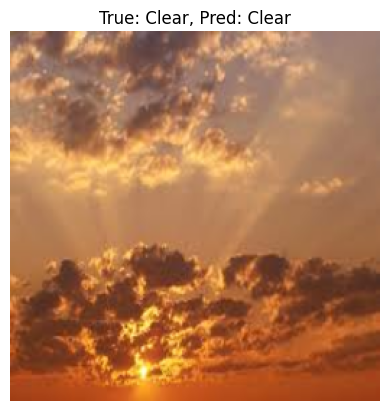

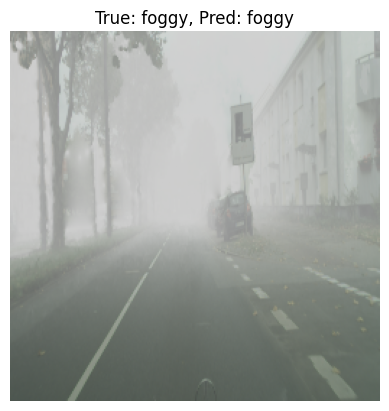

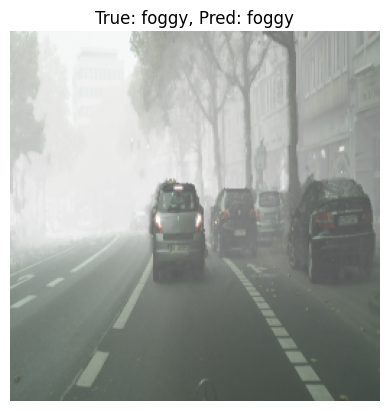

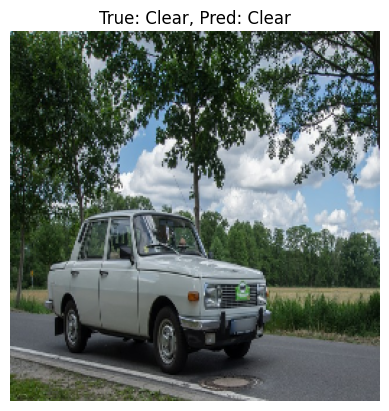

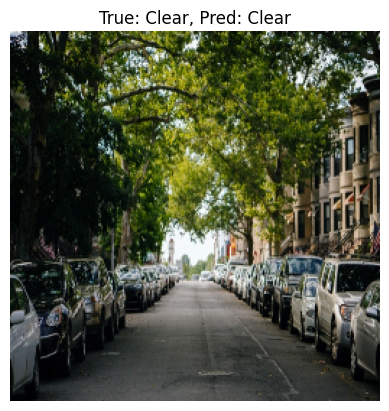

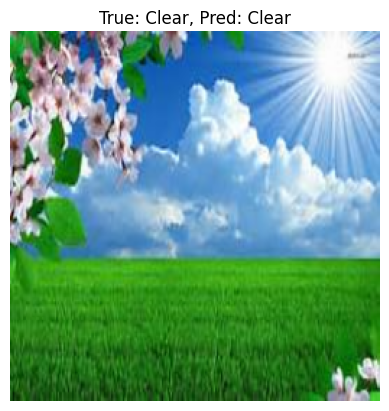

In [ ]:
# Make predictions on the test set
for image_batch, label_batch in test_ds.take(1):
    predictions = model.predict(image_batch)
    for i in range(len(image_batch)):
        plt.imshow(image_batch[i].numpy())
        plt.title(f"True: {dataset.class_names[label_batch[i]]}, Pred: {dataset.class_names[np.argmax(predictions[i])]}")
        plt.axis("off")
        plt.show() # Fixed indentation

In [ ]:
def predict(model,img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array, 0)
  predictions = model.predict(img_array)

  predicted_class = dataset.class_names[np.argmax(predictions[0])]
  confidence = round(100 * (np.max(predictions[0])), 2)
  return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


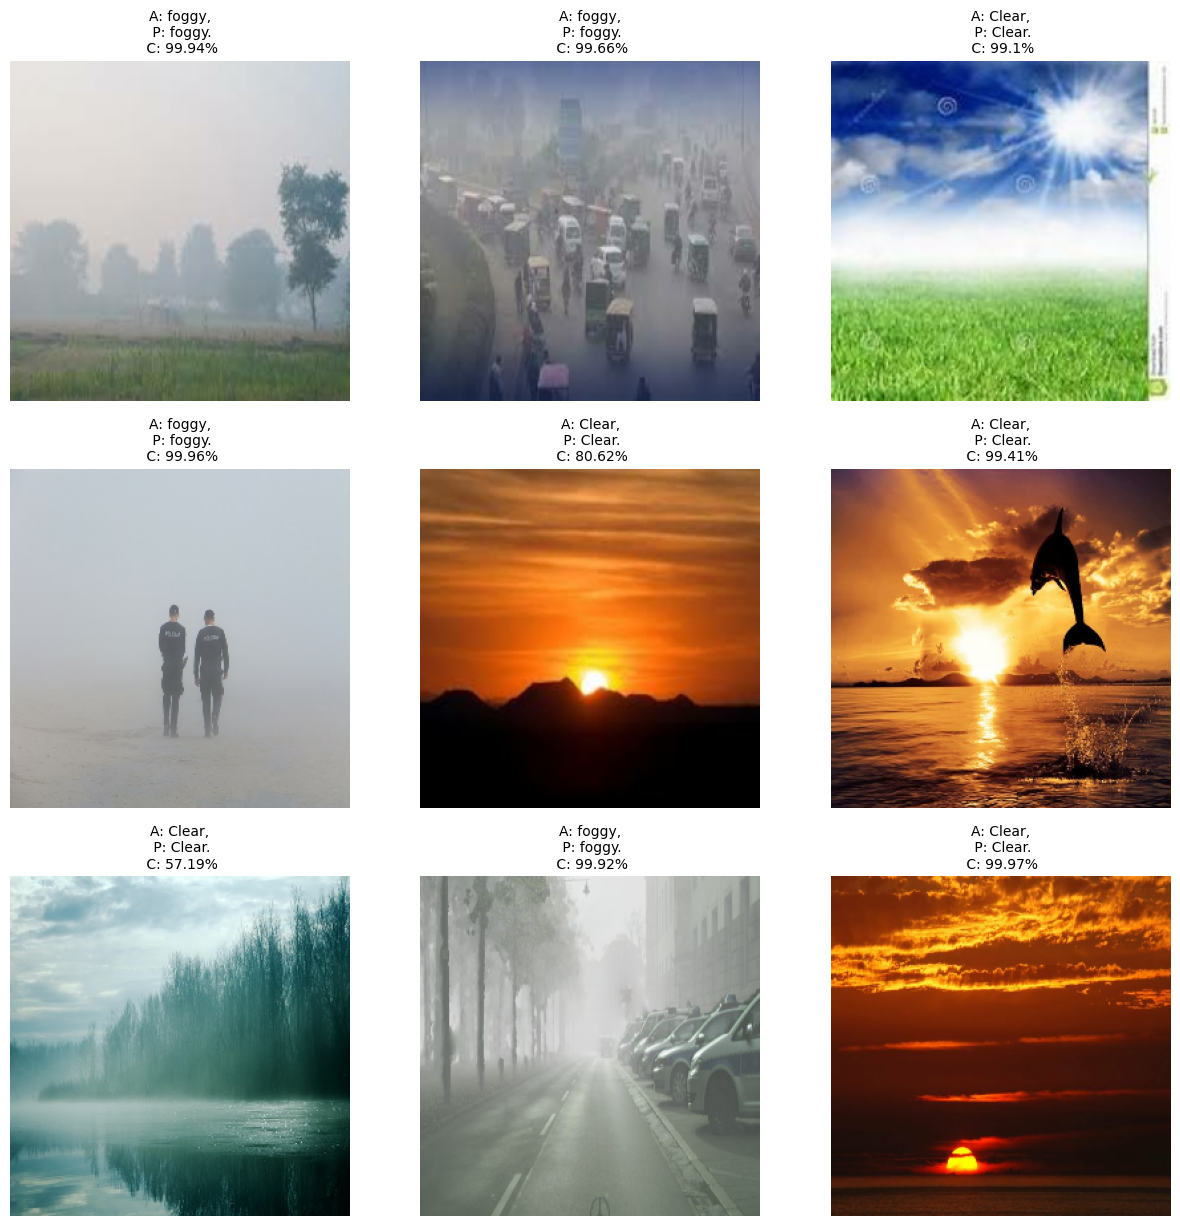

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy())
    predicted_class, confidence = predict(model, images[i].numpy())
    actual_class = dataset.class_names[labels[i]]
    plt.title(f"A: {actual_class},\n P: {predicted_class}.\n C: {confidence}%", fontsize=10)
    plt.axis("off")


In [ ]:
import os
[os.listdir("../models")]

[['2.keras']]

In [ ]:
model_version = 2
model_dir = "../models"  # Path to save the model
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Now save the model
model.save(f"{model_dir}/{model_version}.keras")

In [ ]:
import os
model_version=max([int(i.split(".")[0]) if i.split(".")[0].isdigit() else 0 for i in os.listdir("../models") if isinstance(i, str)] or [0])+1 # Added a check to ensure i is a string before attempting to split it. If the list is empty, or [0] is used instead
model.save(f"../models/{model_version}.keras")

In [ ]:
import os

# Create a directory named 'saved_models/1'
os.makedirs("saved_models/1", exist_ok=True)

# Save the model using the .keras extension to indicate the HDF5 format
model.save("saved_models/1/my_model.keras")  # Changed the filename to include .keras extension

print("Model saved in 'saved_models/1/my_model.keras'") # Updated print statement to reflect the new filename

In [ ]:
import pickle

In [ ]:
with open("model_pickle", "wb") as f:
    pickle.dump(model, f)

In [ ]:
with open("model_pickle", "rb") as f:
    mp = pickle.load(f)

In [ ]:
from google.colab import drive

# Mount the drive to a folder (for example, "/content/drive/MyDrive")
drive.mount('/content/drive')


In [ ]:
# Access a specific notebook or file
notebook_path = '/content/drive/MyDrive/ColabNotebooks/updated_smog-fog.ipynb'


In [ ]:
import os

# Create a directory named 'saved_models/1'
os.makedirs("saved_models/1", exist_ok=True)

# Save the model using the .keras extension to indicate the HDF5 format
model.save("saved_models/1/my_model.keras")  # Changed the filename to include .keras extension

print("Model saved in 'saved_models/1/my_model.keras'") # Updated print statement to reflect the new filename

Model saved in 'saved_models/1/my_model.keras'


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Define the directory to save the model in Google Drive
model_dir = '/content/drive/MyDrive/ColabNotebooks'  # Path to save the model

In [ ]:
# Create directory if it doesn't exist
import os
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

In [ ]:
# Save the model
model_version = 2  # You can change this version number as needed
model.save(f"{model_dir}/{model_version}.keras")

In [ ]:
# Verify the model is saved
print("Saved models:", os.listdir(model_dir))

Saved models: ['2.keras']


In [ ]:
import os

# Create a directory named 'models'
os.makedirs("models", exist_ok=True)

# Save the model using the Keras native format
model.save("models/my_model.keras")
print("Model saved to models/my_model.keras")


Model saved to models/my_model.keras


In [ ]:
import os

model_path = "saved_models/1.keras"
if os.path.exists(model_path):
    model = tf.keras.models.load_model(model_path)
    print("Model loaded successfully.")
else:
    print(f"Model file not found at {model_path}. Please check the path.")


Model file not found at saved_models/1.keras. Please check the path.


In [ ]:
import tensorflow as tf
import numpy as np
from catboost import CatBoostClassifier

# Load the pre-trained CNN model (assuming it is saved in the '.keras' format)
model = tf.keras.models.load_model("models/my_model.keras")

# Create a dummy input to build the model
dummy_input = np.zeros((1, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))  # A dummy image

# Call the model with the dummy input to build it
_ = model(dummy_input)  # The underscore (_) is used to discard the output

# Creating a new input layer to be used with the feature_extractor model
input_layer = tf.keras.layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

# Pass the input layer through the original model's layers to get the desired output
x = model.layers[0](input_layer) # start with the first layer of the model
for layer in model.layers[1:-1]: # iterate through all layers except the first and last
  x = layer(x)
cnn_features = x

# Create a Keras Model to extract features from the CNN
feature_extractor = tf.keras.models.Model(inputs=input_layer, outputs=cnn_features)

# Prepare train_images and train_labels
train_images = []
train_labels = []
for images, labels in train_ds:  # Iterate through batches in train_ds
    for image, label in zip(images.numpy(), labels.numpy()):  # Iterate through individual images in a batch
        train_images.append(image)
        train_labels.append(label)
train_images = np.array(train_images)

# Prepare val_images and val_labels similar to train_images and train_labels
val_images = []
val_labels = []
for images, labels in val_ds:  # Iterate through batches in val_ds
    for image, label in zip(images.numpy(), labels.numpy()):
        val_images.append(image)
        val_labels.append(label)
val_images = np.array(val_images)

# Prepare test_images and test_labels similar to train_images and train_labels
test_images = []
test_labels = []
for images, labels in test_ds:  # Iterate through batches in test_ds
    for image, label in zip(images.numpy(), labels.numpy()):
        test_images.append(image)
        test_labels.append(label)
test_images = np.array(test_images)

# Predict features using the feature extractor
train_features = feature_extractor.predict(train_images)  # Extract features from training images
val_features = feature_extractor.predict(val_images)      # Extract features from validation images
test_features = feature_extractor.predict(test_images)    # Extract features from test images

# Now train CatBoost on the extracted features
catboost_model = CatBoostClassifier(iterations=1000, learning_rate=0.05, depth=6, loss_function='MultiClass')
catboost_model.fit(train_features, train_labels)  # Assuming you have 'train_labels'

# Evaluate on the test set
catboost_predictions = catboost_model.predict(test_features)
test_accuracy = np.mean(catboost_predictions == test_labels) * 100
print(f"CatBoost Test Accuracy: {test_accuracy:.2f}%")

58/58 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step
0:	learn: 0.6663689	total: 120ms	remaining: 2m
1:	learn: 0.6414875	total: 158ms	remaining: 1m 18s
2:	learn: 0.6167277	total: 196ms	remaining: 1m 5s
3:	learn: 0.5942261	total: 232ms	remaining: 57.7s
4:	learn: 0.5740823	total: 271ms	remaining: 54s
5:	learn: 0.5564728	total: 311ms	remaining: 51.5s
6:	learn: 0.5401916	total: 354ms	remaining: 50.3s
7:	learn: 0.5245260	total: 393ms	remaining: 48.8s
8:	learn: 0.5070467	total: 437ms	remaining: 48.2s
9:	learn: 0.4931134	total: 481ms	remaining: 47.6s
10:	learn: 0.4788629	total: 519ms	remaining: 46.7s
11:	learn: 0.4651123	total: 562ms	remaining: 46.2s
12:	learn: 0.4509997	total: 599ms	remaining: 45.5s
13:	learn: 0.4396463	total: 637ms	remaining: 44.9s
14:	learn: 0.4288092	total: 675ms	remaining: 44.3s
15:	learn: 0.4178348	total: 712ms	remaining: 43.8s
16:	learn: 0.4077013	total: 749ms	remaining: 43.3s
17:	learn: 0.3978334	total: 791ms	

In [ ]:
import tensorflow as tf
import numpy as np
import lightgbm as lgb
from sklearn.metrics import accuracy_score

# Load the pre-trained CNN model (assuming it is saved in the '.keras' format)
model = tf.keras.models.load_model("models/my_model.keras")

# Create a dummy input to build the model
dummy_input = np.zeros((1, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))  # A dummy image

# Call the model with the dummy input to build it
_ = model(dummy_input)  # The underscore (_) is used to discard the output

# Creating a new input layer to be used with the feature_extractor model
input_layer = tf.keras.layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

# Pass the input layer through the original model's layers to get the desired output
x = model.layers[0](input_layer)  # Start with the first layer of the model
for layer in model.layers[1:-1]:  # Iterate through all layers except the first and last
    x = layer(x)
cnn_features = x

# Create a Keras Model to extract features from the CNN
feature_extractor = tf.keras.models.Model(inputs=input_layer, outputs=cnn_features)

# Prepare train_images and train_labels
train_images = []
train_labels = []
for images, labels in train_ds:  # Iterate through batches in train_ds
    for image, label in zip(images.numpy(), labels.numpy()):  # Iterate through individual images in a batch
        train_images.append(image)
        train_labels.append(label)
train_images = np.array(train_images)

# Prepare val_images and val_labels similar to train_images and train_labels
val_images = []
val_labels = []
for images, labels in val_ds:  # Iterate through batches in val_ds
    for image, label in zip(images.numpy(), labels.numpy()):
        val_images.append(image)
        val_labels.append(label)
val_images = np.array(val_images)

# Prepare test_images and test_labels similar to train_images and train_labels
test_images = []
test_labels = []
for images, labels in test_ds:  # Iterate through batches in test_ds
    for image, label in zip(images.numpy(), labels.numpy()):
        test_images.append(image)
        test_labels.append(label)
test_images = np.array(test_images)

# Predict features using the feature extractor
train_features = feature_extractor.predict(train_images)  # Extract features from training images
val_features = feature_extractor.predict(val_images)      # Extract features from validation images
test_features = feature_extractor.predict(test_images)    # Extract features from test images

# Now train LightGBM on the extracted features
lgb_model = lgb.LGBMClassifier(n_estimators=1000, learning_rate=0.05, max_depth=6)
lgb_model.fit(train_features, train_labels)  # Assuming you have 'train_labels'

# Evaluate on the test set
lgb_predictions = lgb_model.predict(test_features)
test_accuracy = accuracy_score(test_labels, lgb_predictions) * 100
print(f"LightGBM Test Accuracy: {test_accuracy:.2f}%")


58/58 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step
[LightGBM] [Info] Number of positive: 975, number of negative: 881
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001932 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19987
[LightGBM] [Info] Number of data points in the train set: 1856, number of used features: 98
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.525323 -> initscore=0.101380
[LightGBM] [Info] Start training from score 0.101380
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

In [ ]:
import tensorflow as tf
import numpy as np
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Load the pre-trained CNN model (assuming it is saved in the '.keras' format)
model = tf.keras.models.load_model("models/my_model.keras")
# Create a dummy input to build the model
dummy_input = np.zeros((1, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))  # A dummy image

# Call the model with the dummy input to build it
_ = model(dummy_input)  # The underscore (_) is used to discard the output

# Creating a new input layer to be used with the feature_extractor model
input_layer = tf.keras.layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

# Pass the input layer through the original model's layers to get the desired output
x = model.layers[0](input_layer)  # Start with the first layer of the model
for layer in model.layers[1:-1]:  # Iterate through all layers except the first and last
    x = layer(x)
cnn_features = x

# Create a Keras Model to extract features from the CNN
feature_extractor = tf.keras.models.Model(inputs=input_layer, outputs=cnn_features)

# Prepare train_images and train_labels
train_images = []
train_labels = []
for images, labels in train_ds:  # Iterate through batches in train_ds
    for image, label in zip(images.numpy(), labels.numpy()):  # Iterate through individual images in a batch
        train_images.append(image)
        train_labels.append(label)
train_images = np.array(train_images)

# Prepare val_images and val_labels similar to train_images and train_labels
val_images = []
val_labels = []
for images, labels in val_ds:  # Iterate through batches in val_ds
    for image, label in zip(images.numpy(), labels.numpy()):
        val_images.append(image)
        val_labels.append(label)
val_images = np.array(val_images)

# Prepare test_images and test_labels similar to train_images and train_labels
test_images = []
test_labels = []
for images, labels in test_ds:  # Iterate through batches in test_ds
    for image, label in zip(images.numpy(), labels.numpy()):
        test_images.append(image)
        test_labels.append(label)
test_images = np.array(test_images)

# Predict features using the feature extractor
train_features = feature_extractor.predict(train_images)  # Extract features from training images
val_features = feature_extractor.predict(val_images)      # Extract features from validation images
test_features = feature_extractor.predict(test_images)    # Extract features from test images

# Convert the features to DMatrix format (required by XGBoost)
train_dmatrix = xgb.DMatrix(train_features, label=train_labels)
val_dmatrix = xgb.DMatrix(val_features, label=val_labels)
test_dmatrix = xgb.DMatrix(test_features, label=test_labels)

# Now train XGBoost on the extracted features
params = {
    'objective': 'multi:softmax',  # Multi-class classification
    'num_class': 3,  # Adjust to the number of classes in your problem
    'eval_metric': 'merror',  # Multi-class error metric
    'learning_rate': 0.05,
    'max_depth': 6,
    'n_estimators': 1000
}

xgb_model = xgb.train(params, train_dmatrix, num_boost_round=1000, evals=[(val_dmatrix, 'eval')])

# Evaluate on the test set
xgb_predictions = xgb_model.predict(test_dmatrix)
test_accuracy = accuracy_score(test_labels, xgb_predictions) * 100
print(f"XGBoost Test Accuracy: {test_accuracy:.2f}%")


58/58 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step
[0]	eval-merror:0.04018


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:28:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[1]	eval-merror:0.04018
[2]	eval-merror:0.03571
[3]	eval-merror:0.03571
[4]	eval-merror:0.03125
[5]	eval-merror:0.03571
[6]	eval-merror:0.03125
[7]	eval-merror:0.02679
[8]	eval-merror:0.02679
[9]	eval-merror:0.02232
[10]	eval-merror:0.02232
[11]	eval-merror:0.02232
[12]	eval-merror:0.02679
[13]	eval-merror:0.02679
[14]	eval-merror:0.02232
[15]	eval-merror:0.02679
[16]	eval-merror:0.02679
[17]	eval-merror:0.02679
[18]	eval-merror:0.02679
[19]	eval-merror:0.02232
[20]	eval-merror:0.02232
[21]	eval-merror:0.02232
[22]	eval-merror:0.01786
[23]	eval-merror:0.01339
[24]	eval-merror:0.01339
[25]	eval-merror:0.01339
[26]	eval-merror:0.01339
[27]	eval-merror:0.01339
[28]	eval-merror:0.01339
[29]	eval-merror:0.01339
[30]	eval-merror:0.01339
[31]	eval-merror:0.01339
[32]	eval-merror:0.01339
[33]	eval-merror:0.01339
[34]	eval-merror:0.01339
[35]	eval-merror:0.01339
[36]	eval-merror:0.01339
[37]	eval-merror:0.00893
[38]	eval-merror:0.00893
[39]	eval-merror:0.00893
[40]	eval-merror:0.00893
[41]	eval

In [ ]:
import tensorflow as tf
import numpy as np
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression  # Import LogisticRegression


# ... (Your existing code to prepare datasets and features) ...


# Convert the features to DMatrix format (required by XGBoost)
train_dmatrix = xgb.DMatrix(train_features, label=train_labels)
val_dmatrix = xgb.DMatrix(val_features, label=val_labels)
test_dmatrix = xgb.DMatrix(test_features, label=test_labels)

# Now train XGBoost on the extracted features
params = {
    'objective': 'multi:softmax',  # Multi-class classification
    'num_class': 3,  # Adjust to the number of classes in your problem
    'eval_metric': 'merror',  # Multi-class error metric
    'learning_rate': 0.05,
    'max_depth': 6,
    'n_estimators': 1000
}

# Train the XGBoost model (this is the crucial step that was missing)
xgb_model = xgb.train(params, train_dmatrix, num_boost_round=1000, evals=[(val_dmatrix, 'eval')])


# --- Start of the Stacking code ---
# Get predictions for the training set
xgb_predictions_train = xgb_model.predict(train_dmatrix)
lgb_predictions_train = lgb_model.predict(train_features)
catboost_predictions_train = catboost_model.predict(train_features)

# Get predictions for the test set
xgb_predictions_test = xgb_model.predict(test_dmatrix)
lgb_predictions_test = lgb_model.predict(test_features)
catboost_predictions_test = catboost_model.predict(test_features)

# Create a stacked feature set for training
stacking_features_train = np.column_stack([
    xgb_predictions_train,  # Predictions from XGBoost
    lgb_predictions_train,  # Predictions from LightGBM
    catboost_predictions_train  # Predictions from CatBoost
])

# Create a stacked feature set for testing
stacking_features_test = np.column_stack([
    xgb_predictions_test,  # Predictions from XGBoost
    lgb_predictions_test,  # Predictions from LightGBM
    catboost_predictions_test  # Predictions from CatBoost
])

# Train a meta-model (e.g., logistic regression)
meta_model = LogisticRegression()  # Create a LogisticRegression model
meta_model.fit(stacking_features_train, train_labels)  # Fit the meta-model

# Evaluate the meta-model
meta_predictions = meta_model.predict(stacking_features_test)
meta_accuracy = accuracy_score(test_labels, meta_predictions) * 100
print(f"Stacked Model Test Accuracy: {meta_accuracy:.2f}%")
# --- End of the Stacking code ---

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:29:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	eval-merror:0.04018
[1]	eval-merror:0.04018
[2]	eval-merror:0.03571
[3]	eval-merror:0.03571
[4]	eval-merror:0.03125
[5]	eval-merror:0.03571
[6]	eval-merror:0.03125
[7]	eval-merror:0.02679
[8]	eval-merror:0.02679
[9]	eval-merror:0.02232
[10]	eval-merror:0.02232
[11]	eval-merror:0.02232
[12]	eval-merror:0.02679
[13]	eval-merror:0.02679
[14]	eval-merror:0.02232
[15]	eval-merror:0.02679
[16]	eval-merror:0.02679
[17]	eval-merror:0.02679
[18]	eval-merror:0.02679
[19]	eval-merror:0.02232
[20]	eval-merror:0.02232
[21]	eval-merror:0.02232
[22]	eval-merror:0.01786
[23]	eval-merror:0.01339
[24]	eval-merror:0.01339
[25]	eval-merror:0.01339
[26]	eval-merror:0.01339
[27]	eval-merror:0.01339
[28]	eval-merror:0.01339
[29]	eval-merror:0.01339
[30]	eval-merror:0.01339
[31]	eval-merror:0.01339
[32]	eval-merror:0.01339
[33]	eval-merror:0.01339
[34]	eval-merror:0.01339
[35]	eval-merror:0.01339
[36]	eval-merror:0.01339
[37]	eval-merror:0.00893
[38]	eval-merror:0.00893
[39]	eval-merror:0.00893
[40]	eval-

In [ ]:
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import numpy as np

# Define individual models
xgb_model = XGBClassifier()
catboost_model = CatBoostClassifier(iterations=1000, learning_rate=0.05, depth=6, loss_function='MultiClass')
lgb_model = LGBMClassifier()

# Create an ensemble model using soft voting (averaging probabilities)
ensemble_model = VotingClassifier(estimators=[('xgb', xgb_model), ('catboost', catboost_model), ('lgb', lgb_model)], voting='soft')

# Fit the ensemble model
ensemble_model.fit(train_features, train_labels)

# Get predicted probabilities (soft voting) from the ensemble
ensemble_predictions_proba = ensemble_model.predict_proba(test_features)

# Get the class with the highest probability for each sample
ensemble_predictions = np.argmax(ensemble_predictions_proba, axis=1)

# Evaluate accuracy
test_accuracy = np.mean(ensemble_predictions == test_labels) * 100
print(f"Ensemble Model Test Accuracy: {test_accuracy:.2f}%")


0:	learn: 0.6669641	total: 72.9ms	remaining: 1m 12s
1:	learn: 0.6422134	total: 119ms	remaining: 59.6s
2:	learn: 0.6200250	total: 157ms	remaining: 52.3s
3:	learn: 0.5980377	total: 194ms	remaining: 48.3s
4:	learn: 0.5766308	total: 231ms	remaining: 46s
5:	learn: 0.5584378	total: 268ms	remaining: 44.4s
6:	learn: 0.5399534	total: 310ms	remaining: 43.9s
7:	learn: 0.5239641	total: 348ms	remaining: 43.2s
8:	learn: 0.5064135	total: 385ms	remaining: 42.4s
9:	learn: 0.4910369	total: 432ms	remaining: 42.8s
10:	learn: 0.4765952	total: 478ms	remaining: 42.9s
11:	learn: 0.4635367	total: 517ms	remaining: 42.6s
12:	learn: 0.4515101	total: 556ms	remaining: 42.3s
13:	learn: 0.4388880	total: 594ms	remaining: 41.8s
14:	learn: 0.4270577	total: 631ms	remaining: 41.5s
15:	learn: 0.4158034	total: 672ms	remaining: 41.3s
16:	learn: 0.4051479	total: 709ms	remaining: 41s
17:	learn: 0.3942744	total: 751ms	remaining: 40.9s
18:	learn: 0.3850717	total: 788ms	remaining: 40.7s
19:	learn: 0.3772911	total: 825ms	remaining

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

def grad_cam(model, image, class_idx):
    """Generates a Grad-CAM heatmap for a given image and class index."""
    # Extract features from the input image using the feature extractor
    image_features = feature_extractor.predict(image)

    # Ensure the model has been called on a dummy input to initialize its layers
    # Use the ensemble_model for prediction instead of the original model
    ensemble_model.predict(image_features)  # Changed to ensemble_model

    # Select the target convolutional layer by its name (replace 'conv2d_3' with the correct name)
    # Find the last convolutional layer's name
    last_conv_layer_name = None
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Conv2D):
            last_conv_layer_name = layer.name

    if last_conv_layer_name is None:
        raise ValueError("No convolutional layers found in the model.")

    # Build the Grad-CAM model
    # Ensure the model is built by calling it with a dummy input
    _ = model(tf.zeros((1, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)))
    grad_model = tf.keras.models.Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
        # Change the output order to match the order of predictions, conv_output
    )

    with tf.GradientTape() as tape:
        inputs = tf.convert_to_tensor(image)  # Ensure image is a tensor
        tape.watch(inputs)
        # Change the order of predictions, conv_output to match the grad_model output order
        conv_output, predictions = grad_model(inputs)
        class_output = predictions[:, class_idx]

    gradients = tape.gradient(class_output, conv_output)
    pooled_grads = tf.reduce_mean(gradients, axis=(0, 1, 2))

    # Weigh the output feature map by the pooled gradients
    heatmap = tf.reduce_sum(tf.multiply(conv_output, pooled_grads), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap = cv2.resize(heatmap[0], (image.shape[1], image.shape[0]))
    heatmap = np.uint8(255 * heatmap / np.max(heatmap))

    # Create an overlay with the original image
    img = np.uint8(image[0] * 255)  # Assuming image is in [0, 1] range
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    return superimposed_img

In [ ]:
!pip install -q streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.4/23.4 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.9 MB/s eta 0:00:00
